<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyze-ansatz-state-simulation-costs" data-toc-modified-id="Analyze-ansatz-state-simulation-costs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analyze ansatz state simulation costs</a></span><ul class="toc-item"><li><span><a href="#Time-to-solution-for-different-p" data-toc-modified-id="Time-to-solution-for-different-p-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Time to solution for different p</a></span></li><li><span><a href="#Contraction-width-for-different-ordering-algo" data-toc-modified-id="Contraction-width-for-different-ordering-algo-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Contraction width for different ordering algo</a></span></li><li><span><a href="#Contraction-width-for-different-composer" data-toc-modified-id="Contraction-width-for-different-composer-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Contraction width for different composer</a></span></li><li><span><a href="#Step-dependent-parallelisation" data-toc-modified-id="Step-dependent-parallelisation-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Step-dependent parallelisation</a></span></li><li><span><a href="#Bunch-of-amplitudes" data-toc-modified-id="Bunch-of-amplitudes-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Bunch of amplitudes</a></span></li><li><span><a href="#CLI" data-toc-modified-id="CLI-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>CLI</a></span><ul class="toc-item"><li><span><a href="#Nbdev" data-toc-modified-id="Nbdev-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Nbdev</a></span></li></ul></li></ul></li></ul></div>

In [1]:
#export
import time
import numpy as np
import matplotlib.pyplot as plt
from cartesian_explorer import Explorer
from cartesian_explorer import parallels, caches
import qtensor as qtn

In [2]:
%load_ext autoreload
%autoreload 2

# Analyze ansatz state simulation costs

In [3]:
#export
parallel = parallels.Ray()
cache = caches.JobLibCache('../../../data/a/cache/qaoa_ansatz_skylake/')
ex = Explorer(parallel=parallel, cache=cache)

2020-11-20 05:13:19,641	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


In [4]:
#export    
@ex.provider
def graph(N, d=3, graph_type='random', seed=10):
    return qtn.toolbox.random_graph(nodes=N, type=graph_type, degree=d, seed=seed)

In [5]:
#export
@ex.provider
def ansatz_circ(graph, p, composer_type='default'):
    gamma, beta = [.1]*p, [.3]*p
    if composer_type=='default':
        composer = qtn.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    elif composer_type=='no_zz':
        composer = qtn.OldQtreeQAOAComposer(graph, gamma=gamma, beta=beta)
    elif composer_type=='no_diag':
        composer = qtn.QtreeFullQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.ansatz_state()
    return tuple(composer.circuit)

@ex.provider
def qtensor_time(ansatz_circ, target_tw=24,
                 fail_tw=45,
                 qtn_ordering_algo='greedy',
                 batch_vars=0,
                 par_vars=0,
                 slicing_algo=None
                ):
    """
    Args:
        ansatz_circ (list): qtree circuit
        target_tw: slice until reached
        fail_tw: if initial tw is larger, fail
        qtn_ordering_algo: ordering algorithm
        batch_vars: log2 of number of amplitudes to simulate
    Returns:
        time to sample amplitude from 
    """
    if par_vars:
        optimizer = qtn.toolbox.get_slicing_algo(
            slicing_algo, par_vars, ordering_algo=qtn_ordering_algo
        )
    else:
        optimizer = qtn.toolbox.get_ordering_algo(qtn_ordering_algo, par_vars=par_vars)
    
    
    
    sim = qtn.QtreeSimulator(optimizer=optimizer, max_tw=fail_tw)
    start = time.time()
    try:
        sim.simulate(ansatz_circ)
    except Exception as e:
        print('Exception:', e)
        return None
    end = time.time()
    return end - start


In [6]:
t = ex.get_variable('qtensor_time', N=10, p=2, fail_tw=20)
t

0.010996580123901367

In [7]:
#export
@ex.provider
def qtensor_tw(ansatz_circ, target_tw=24,
               qtn_ordering_algo='greedy',
               batch_vars=0,
               par_vars=0,
               slicing_algo=None,
               amplitudes_batch=0
              ):
    """
    Args:
        ansatz_circ (list): qtree circuit
        target_tw: slice until reached
        qtn_ordering_algo: ordering algorithm
        batch_vars: log2 of number of amplitudes to simulate
    Returns:
        time to sample amplitude from 
    """
    if par_vars:
        optimizer = qtn.toolbox.get_slicing_algo(
            slicing_algo, par_vars, ordering_algo=qtn_ordering_algo
        )
    else:
        optimizer = qtn.toolbox.get_ordering_algo(qtn_ordering_algo, par_vars=par_vars)
    tn = qtn.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(ansatz_circ)
    if amplitudes_batch:
        tn.set_free_qubits(range(amplitudes_batch))
    optimizer.optimize(tn)
    return optimizer.treewidth
    


In [8]:
#Ns = 2*(.2*np.pi**(np.arange(0, 11)/2)).astype(np.int) + 6
Ns = 2*np.linspace(5, 75, 11, dtype=int)

## Time to solution for different p

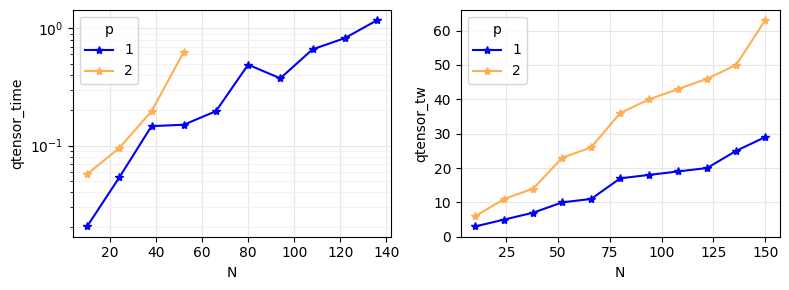

In [10]:
def custom_plot(x, y, **kwargs):
    plt.plot(x, y, '*-', **kwargs)
    plt.yscale('log')
fig = ex.plot_variables(('qtensor_time','qtensor_tw'),
                        plot_func=custom_plot,
                        p=[1,2], N=Ns,
                        qtn_ordering_algo=['rgreedy_0.02_5'],
                        fail_tw=[26],
                       )
fig.axes[1].set_yscale('linear')

## Contraction width for different ordering algo

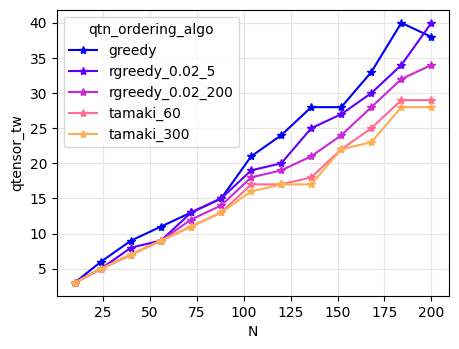

In [27]:
Ns = 2*np.linspace(5, 100, 13, dtype=int)
fig = ex.plot_variables(('qtensor_tw', ),
                        plot_kwargs=dict(marker='*'),
                        p=[1,],
                        qtn_ordering_algo=['greedy',
                                           'rgreedy_0.02_5',
                                           'rgreedy_0.02_200',
                                           'tamaki_60',
                                           'tamaki_300'
                                          ],
                        N=Ns,
                       )
fig.set_size_inches(4.5, 3.5)

## Contraction width for different composer

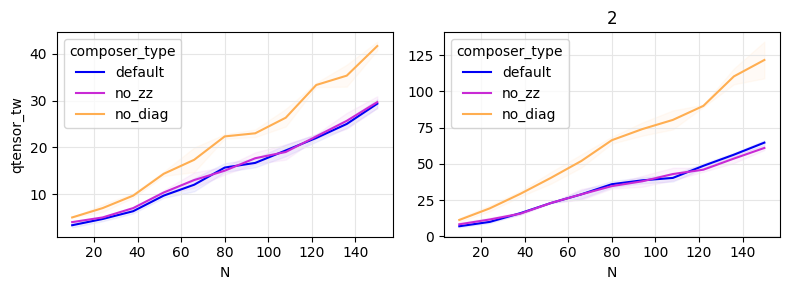

In [84]:
fig = ex.plot_variables(('qtensor_tw', ),
                        distribution_var='seed',
                        p=[1,2],
                        composer_type=['default', 'no_zz', 'no_diag'],
                        N=Ns,
                        seed=[10, 11, 12],
                        qtn_ordering_algo=['rgreedy_0.02_5'],
                       )
fig.axes[1].set_yscale('linear')

In [82]:
c1 = ex.get_variable('ansatz_circ', N=150, composer_type='full', p=1,
                     seed=10, qtn_ordering_algo='rgreedy_0.02_5')
c2 = ex.get_variable('ansatz_circ', N=150, composer_type='default', p=1,
                     seed=10, qtn_ordering_algo='rgreedy_0.02_5')
print(len(c1), len(c2))

975 525


## Step-dependent parallelisation

2020-11-19 01:59:27.397 | INFO     | qtensor.optimisation.late_parallelisation:_get_max_tw:69 - Memory available: 709140480
2020-11-19 01:59:27.437 | INFO     | qtensor.optimisation.late_parallelisation:optimize:139 - Initial treewidth: 13
2020-11-19 01:59:30.558 | INFO     | qtensor.optimisation.late_parallelisation:optimize:157 - Sliced 1, next treewidth: 10
2020-11-19 01:59:33.848 | INFO     | qtensor.optimisation.late_parallelisation:optimize:157 - Sliced 1, next treewidth: 9
2020-11-19 01:59:33.849 | INFO     | qtensor.optimisation.late_parallelisation:optimize:163 - Removed 2 variables, reduced tw by 4
2020-11-19 01:59:33.852 | INFO     | qtensor.optimisation.late_parallelisation:_get_max_tw:69 - Memory available: 856395776
2020-11-19 01:59:33.926 | INFO     | qtensor.optimisation.late_parallelisation:optimize:139 - Initial treewidth: 18
2020-11-19 01:59:39.719 | INFO     | qtensor.optimisation.late_parallelisation:optimize:157 - Sliced 1, next treewidth: 14
2020-11-19 01:59:44.4

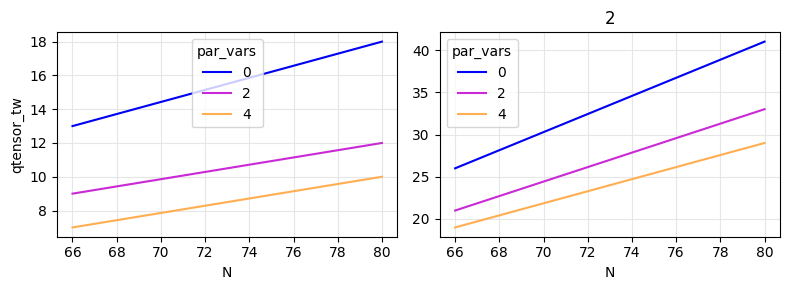

In [33]:
fig = ex.plot_variables(('qtensor_tw', ),
                        p=[1,2],
                        par_vars=[0, 2, 4],
                        N=Ns[4:-5],
                        qtn_ordering_algo=['greedy'],
                        slicing_algo=['late-slice_1'],
                       )
fig.axes[1].set_yscale('linear')

2020-11-19 02:34:17.681 | INFO     | qtensor.optimisation.late_parallelisation:_get_max_tw:79 - Memory available: 1030803456
2020-11-19 02:34:17.755 | INFO     | qtensor.optimisation.late_parallelisation:optimize:149 - Initial treewidth: 19
2020-11-19 02:34:28.258 | INFO     | qtensor.optimisation.late_parallelisation:optimize:167 - Sliced 1, next treewidth: 16
2020-11-19 02:34:28.259 | INFO     | qtensor.optimisation.late_parallelisation:optimize:173 - Removed 1 variables, reduced tw by 3
2020-11-19 02:34:28.263 | INFO     | qtensor.optimisation.late_parallelisation:_get_max_tw:79 - Memory available: 1029144576
2020-11-19 02:34:28.363 | INFO     | qtensor.optimisation.late_parallelisation:optimize:149 - Initial treewidth: 19
2020-11-19 02:34:38.685 | INFO     | qtensor.optimisation.late_parallelisation:optimize:167 - Sliced 1, next treewidth: 16
2020-11-19 02:34:44.338 | INFO     | qtensor.optimisation.late_parallelisation:optimize:167 - Sliced 1, next treewidth: 15
2020-11-19 02:34:4

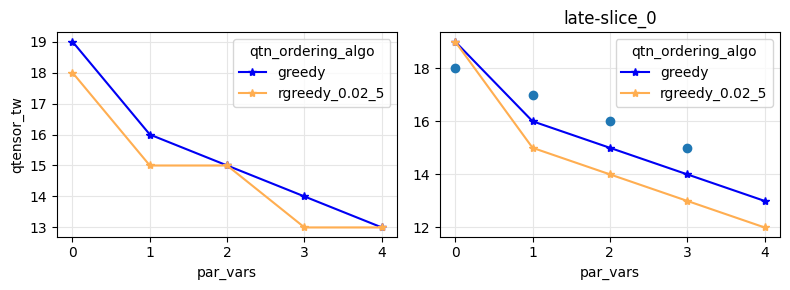

In [46]:
fig = ex.plot_variables(('qtensor_tw', ),
                        plot_kwargs=dict(marker='*'),
                        
                        slicing_algo=['late-slice_1', 'late-slice_0'],
                        qtn_ordering_algo=['greedy', 'rgreedy_0.02_5'],
                        par_vars=[0, 1, 2, 3, 4],
                        p=[1],
                        N=[100],
                       )
plt.plot(range(4), range(18, 14, -1), 'o')

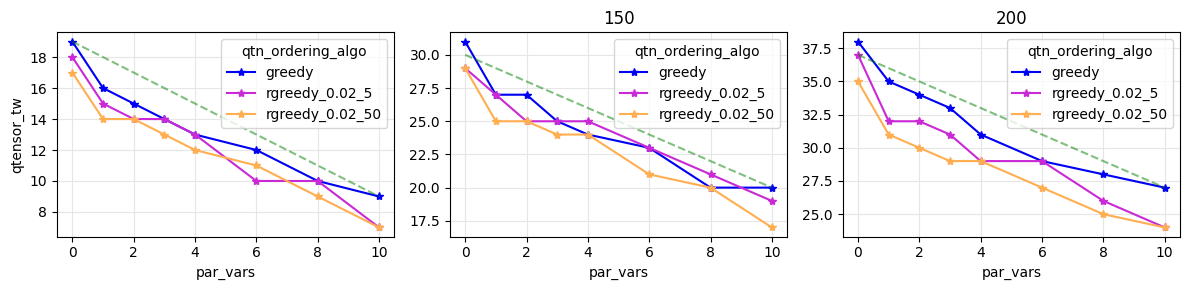

In [20]:
fig = ex.plot_variables(('qtensor_tw', ),
                        plot_kwargs=dict(marker='*'),
                        
                        N=[100, 150, 200],
                        qtn_ordering_algo=['greedy', 'rgreedy_0.02_5', 'rgreedy_0.02_50'],
                        par_vars=[0, 1, 2, 3, 4, 6, 8, 10],
                        p=[1],
                        slicing_algo=['late-slice_1'],
                       )
diag_ = range(19, 8, -1)
fig.axes[0].plot(range(len(diag_)), diag_, 'g--', alpha=.5)

diag_ = range(30, 19, -1)
fig.axes[1].plot(range(len(diag_)), diag_, 'g--', alpha=.5)

diag_ = range(37, 26, -1)
fig.axes[2].plot(range(len(diag_)), diag_, 'g--', alpha=.5)
fig.tight_layout()

In [ ]:
fig = ex.plot_variables(('qtensor_tw', ),
                        plot_kwargs=dict(marker='*'),
                        
                        N=[100, 150, 200],
                        slicing_algo=['late-slice_2', 'late-slice_1', 'late-slice_0'],
                        qtn_ordering_algo=['rgreedy_0.02_5'],
                        par_vars=[0, 1, 2, 4, 6, 10],
                        p=[1],
                       )
diag_1 = range(19, 10, -1)

diag_ = range(19, 8, -1)
fig.axes[0].plot(range(len(diag_)), diag_, 'g--', alpha=.5)

diag_ = range(30, 19, -1)
fig.axes[1].plot(range(len(diag_)), diag_, 'g--', alpha=.5)

diag_ = range(37, 26, -1)
.plot(range(len(diag_)), diag_, 'g--', alpha=.5)

## Bunch of amplitudes

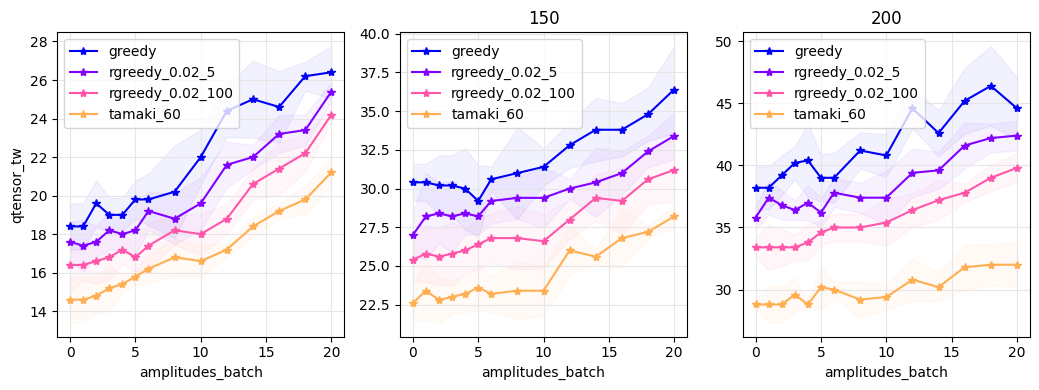

In [26]:
fig = ex.plot_variables(('qtensor_tw', ),
                        plot_kwargs=dict(marker='*'),
                        distribution_var='seed',
                        
                        N=[100, 150, 200],
                        qtn_ordering_algo=['greedy', 'rgreedy_0.02_5', 'rgreedy_0.02_100', 'tamaki_60'],
                        amplitudes_batch=[0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20],
                        seed=[10, 11, 12, 13, 14],
                        p=[1],
                        slicing_algo=['late-slice_1'],
                       )

for ax in fig.axes:
    ax.legend(loc='upper left')
    
fig.set_size_inches(10.5, 4.)
fig.tight_layout()

In [71]:
fig = ex.plot_variables(('qtensor_tw', ),
                        plot_kwargs=dict(marker='*'),
                        
                        N=[150],
                        qtn_ordering_algo=['greedy', 'rgreedy_0.02_5', 'rgreedy_0.02_100'],
                        par_vars=[0, 1, 2, 3, 4],
                        
                        amplitudes_batch=[0, 1, 2, 4, 5, 8, 16],
                        p=[1],
                        slicing_algo=['late-slice_1'],
                       )

2020-11-19 11:02:08.686 | INFO     | qtensor.optimisation.late_parallelisation:_get_max_tw:79 - Memory available: 184107008
2020-11-19 11:02:08.802 | INFO     | qtensor.optimisation.late_parallelisation:optimize:149 - Initial treewidth: 31
2020-11-19 11:02:48.971 | INFO     | qtensor.optimisation.late_parallelisation:optimize:167 - Sliced 1, next treewidth: 27
2020-11-19 11:02:48.972 | INFO     | qtensor.optimisation.late_parallelisation:optimize:172 - Removed 1 variables, reduced tw by 4
2020-11-19 11:02:48.973 | WARNING  | qtensor.optimisation.late_parallelisation:optimize:176 - Not all free variables are in the last ordering chunk!


AssertionError: Algorithmic error. Investigate

In [ ]:
def gen_time_data(Ns, ps, **kwargs):
xar = ex.get_variables_xarray(
    ('qtensor_time', 'quimb_time'),
    p=ps,
    N=Ns,
    **kwargs,
)
return xar

## CLI

In [5]:
#export
from qtensor_specs import cli
import click

/home/dali/git-bulit/cotengra/cotengra/hyper.py:18: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [12]:
#export
@cli.command()
@click.argument('filename')
@click.option('--n_len', default=4)
@click.option('--p_len', default=2)
@click.option('-O', '--qtn_ordering_algo', default='greedy')
@click.option('-N', '--n_processes', default=2)
@click.argument('filename')
def qaoa_ansatz_time(filename, n_len, p_len, **kwargs):
    Ns = 2*(.5*np.pi**(np.arange(0, 12)/2)).astype(np.int) + 10
    Ns = Ns[:n_len]
    ps = [2, 3, 4]
    ps = ps[:p_len]
    kwargs = {k:[v] for k, v in kwargs.items()}
    xar = gen_time_data(Ns, ps, **kwargs)
    xar.to_netcdf(filename)
    
    

### Nbdev

In [3]:
#hide
#default_exp qaoa_ansatz_complexity

from nbdev.export import *
notebook2script()

Converted QAOA_bench.ipynb.
Converted Speed_comparison.ipynb.
Converted Time_vs_FLOP.ipynb.
Converted index.ipynb.
Converted qaoa_ansatz_complexity.ipynb.
